<a href="https://colab.research.google.com/github/rurusasu/RecommendSystem/blob/main/TowTowerRecommendModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TowTowerRecommendModel を試験的に作成する
参考:
* [1つの Two-Tower モデルで4種類の推薦を実現する](https://qiita.com/rayuron/items/cc04468de7af3d82bac2)
* [Two-Tower Recommendationについて](https://qiita.com/akira_saigo/items/fb07c970febc872d22e3)

データセット: MovieLens-100k

In [ ]:
# Googleドライブのマウント
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
base_dir = "/content/drive/MyDrive/ColabNotebooks"

In [ ]:
!pip install  --upgrade -q tensorflow_recommenders tensorflow-datasets apache-beam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 669.1/669.1 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 81.1 MB/

In [ ]:
import os
import tempfile

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.style.use("seaborn-whitegrid")

<ipython-input-5-4ae0939fc385>:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


# MovieLens Test

## データ読み出しと前処理

In [ ]:
# データのダウンロードと読み出し
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

print(ratings)
print(movies)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/incomplete.LORI3Y_0.1.1/movielens-train.tfrecord*..…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-movies/incomplete.690XXO_0.1.1/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.1. Subsequent calls will reuse this data.
<_PrefetchDataset element_spec={'bucketized_user_age': TensorSpec(shape=(), dtype=tf.float32, name=None), 'movie_genres': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'movie_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'movie_title': TensorSpec(shape=(), dtype=tf.string, name=None), 'raw_user_age': TensorSpec(shape=(), dtype=tf.float32, name=None), 'timestamp': TensorSpec(shape=(), dtype=tf.int64, name=None), 'user_gender': TensorSpec(shape=(), dtype=tf.bool, name=None), 'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_occupation_label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'user_occupation_text': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_rating': TensorSpec(shape=(), dtype=tf.float32, name=None), 'user_zip_code': TensorSpec(shape=(), dtype=tf.string, name=None)}>
<_PrefetchDataset eleme

In [ ]:
# 必要な項目の抽出
ratings = ratings.map(
    lambda x: {
        "movie_title": x["movie_title"],
        "user_id": x["user_id"],
        "timestamp": x["timestamp"],
    }
)
movies = movies.map(lambda x: x["movie_title"])

timestamps = np.concatenate(
    list(ratings.map(lambda x: x["timestamp"]).batch(100))
)

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp,
    max_timestamp,
    num=1000,
)

print(ratings)
print(movies)
print(timestamps)

<_MapDataset element_spec={'movie_title': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'timestamp': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
<_MapDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
[879024327 875654590 882075110 ... 879795430 892839492 874791894]


In [ ]:
unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(
    np.concatenate(list(ratings.batch(1_000).map(lambda x: x["user_id"])))
)

print(unique_movie_titles)
print(unique_user_ids)

[b"'Til There Was You (1997)" b'1-900 (1994)' b'101 Dalmatians (1996)' ...
 b'Zeus and Roxanne (1997)' b'unknown'
 b'\xc3\x81 k\xc3\xb6ldum klaka (Cold Fever) (1994)']
[b'1' b'10' b'100' b'101' b'102' b'103' b'104' b'105' b'106' b'107' b'108'
 b'109' b'11' b'110' b'111' b'112' b'113' b'114' b'115' b'116' b'117'
 b'118' b'119' b'12' b'120' b'121' b'122' b'123' b'124' b'125' b'126'
 b'127' b'128' b'129' b'13' b'130' b'131' b'132' b'133' b'134' b'135'
 b'136' b'137' b'138' b'139' b'14' b'140' b'141' b'142' b'143' b'144'
 b'145' b'146' b'147' b'148' b'149' b'15' b'150' b'151' b'152' b'153'
 b'154' b'155' b'156' b'157' b'158' b'159' b'16' b'160' b'161' b'162'
 b'163' b'164' b'165' b'166' b'167' b'168' b'169' b'17' b'170' b'171'
 b'172' b'173' b'174' b'175' b'176' b'177' b'178' b'179' b'18' b'180'
 b'181' b'182' b'183' b'184' b'185' b'186' b'187' b'188' b'189' b'19'
 b'190' b'191' b'192' b'193' b'194' b'195' b'196' b'197' b'198' b'199'
 b'2' b'20' b'200' b'201' b'202' b'203' b'204' b'205' b'

## モデル準備

In [ ]:
class UserModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        timestamps = np.concatenate(
            list(ratings.map(lambda x: x["timestamp"]).batch(100))
        )


        self.user_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(
                    vocabulary=unique_user_ids, mask_token=None
                ),
                tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
            ]
        )
        self.timestamp_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Discretization(timestamp_buckets.tolist()),
                tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
            ]
        )
        self.normalized_timestamp = tf.keras.layers.Normalization(axis=None)

        self.normalized_timestamp.adapt(timestamps)

    def call(self, inputs):
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result.
        return tf.concat(
            [
                self.user_embedding(inputs["user_id"]),
                self.timestamp_embedding(inputs["timestamp"]),
                tf.reshape(
                    self.normalized_timestamp(inputs["timestamp"]), (-1, 1)
                ),
            ],
            axis=1,
        )


In [ ]:
class QueryModel(tf.keras.Model):
    """Model for encoding user queries."""

    def __init__(self, layer_sizes):
        """Model for encoding user queries.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        # We first use the user model for generating embeddings.
        self.embedding_model = UserModel()

        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(
                tf.keras.layers.Dense(layer_size, activation="relu")
            )

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [ ]:
class MovieModel(tf.keras.Model):
    def __init__(self):
        super().__init__()

        max_tokens = 10_000

        self.title_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(
                    vocabulary=unique_movie_titles, mask_token=None
                ),
                tf.keras.layers.Embedding(len(unique_movie_titles) + 1, 32),
            ]
        )

        self.title_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=max_tokens
        )

        self.title_text_embedding = tf.keras.Sequential(
            [
                self.title_vectorizer,
                tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
                tf.keras.layers.GlobalAveragePooling1D(),
            ]
        )

        self.title_vectorizer.adapt(movies)

    def call(self, titles):
        return tf.concat(
            [
                self.title_embedding(titles),
                self.title_text_embedding(titles),
            ],
            axis=1,
        )

In [ ]:
class CandidateModel(tf.keras.Model):
    """Model for encoding movies."""

    def __init__(self, layer_sizes):
        """Model for encoding movies.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        self.embedding_model = MovieModel()

        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(
                tf.keras.layers.Dense(layer_size, activation="relu")
            )

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [ ]:
class MovielensModel(tfrs.models.Model):
    def __init__(self, layer_sizes):
        super().__init__()
        self.query_model = QueryModel(layer_sizes)
        self.candidate_model = CandidateModel(layer_sizes)
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=movies.batch(128).map(self.candidate_model),
            ),
        )

    def compute_loss(self, features, training=False):
        # We only pass the user id and timestamp features into the query model. This
        # is to ensure that the training inputs would have the same keys as the
        # query inputs. Otherwise the discrepancy in input structure would cause an
        # error when loading the query model after saving it.
        query_embeddings = self.query_model(
            {
                "user_id": features["user_id"],
                "timestamp": features["timestamp"],
            }
        )
        movie_embeddings = self.candidate_model(features["movie_title"])

        return self.task(
            query_embeddings, movie_embeddings, compute_metrics=not training
        )


## モデルの訓練

In [ ]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

num_epochs = 5
model = MovielensModel([32])


model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

one_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1,
)

accuracy = one_layer_history.history[
    "val_factorized_top_k/top_100_categorical_accuracy"
][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Epoch 1/5
40/40 [==============================] - 23s 410ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 14534.0281 - regularization_loss: 0.0000e+00 - total_loss: 14534.0281 - val_factorized_top_k/top_1_categorical_accuracy: 0.0013 - val_factorized_top_k/top_5_categorical_accuracy: 0.0079 - val_factorized_top_k/top_10_categorical_accuracy: 0.0176 - val_factorized_top_k/top_50_categorical_accuracy: 0.1040 - val_factorized_top_k/top_100_categorical_accuracy: 0.2017 - val_loss: 28370.4297 - val_regularization_loss: 0.0000e+00 - val_total_loss: 28370.4297
Epoch 2/5
40/40 [==============================] - 20s 419ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e

KeyboardInterrupt: 

## モデルの評価

In [ ]:
# user2item
index = tfrs.layers.factorized_top_k.BruteForce(model.query_model)
index.index_from_dataset(
    tf.data.Dataset.zip(
        (movies.batch(100), movies.batch(100).map(model.candidate_model))
    )
)
_, titles = index(
    {"user_id": tf.constant(["42"]), "timestamp": tf.constant([879024327])}
)
display(titles.numpy()[0].tolist())

# 自作データセットで評価

## データセットの読み出しと前処理

In [ ]:
base_dir = "/content/drive/MyDrive/Google AI Studio"

In [ ]:
# エクセルファイルからデータを読み込む
data = pd.read_excel(f"{base_dir}/sample_merged_full.xlsx")

data.head(2)

,user_id,target_id,rating,user_name_target,nickname_target,gender_target,location_target,age_range_target,height_range_target,body_type_target,...,body_type_user,personality_user,appearance_user,job_user,blood_type_user,car_user,interests_user,salary_user,plan_user,account_creation_timestamp_user
0,1,8627.0,0.0,原田遥,アオイ,女性,埼玉県伊奈町,45-49,150-154,普通,...,スリム,元気,セクシー系,会社員,O型,有り,技術・プログラミング,8160000,option2,2024-01-14 00:11:34
1,1,18213.0,0.0,井上萌,ユイ,女性,福島県玉川村,30-34,150-154,スリム,...,スリム,元気,セクシー系,会社員,O型,有り,技術・プログラミング,8160000,option2,2024-01-14 00:11:34


In [ ]:
from tensorflow.keras.utils import to_categorical

# ラベルに不正な値が含まれている可能性があるので、削除
data = data[data['rating'].isin([0, 1, 2])]
# 不要なカラムの削除
data = data.drop(columns=['user_id', 'target_id', 'user_name_target', 'nickname_target',
                     'plan_target', 'account_creation_timestamp_target',
                     'user_name_user', 'nickname_user', 'plan_user',
                     'account_creation_timestamp_user'])

# 特徴量とラベルの分離
features = data.drop(columns=['rating'])
labels = data['rating']
# ラベルをOne-Hotエンコーディング
labels = to_categorical(labels, num_classes=3)

# ユーザーデータとターゲットデータの列を抽出
#user_columns = [col for col in data.columns if '_user' in col]
#target_columns = [col for col in data.columns if '_target' in col]

# ユーザーデータセットとアイテムデータセットを作成
#user_data = data[user_columns].copy()  # Ensure we're working on a copy
#target_data = data[target_columns].copy()  # Ensure we're working on a copy

# カラム名から_target, _userを削除
#user_data.columns = [col.replace('_user', '') for col in user_data.columns]
#target_data.columns = [col.replace('_target', '') for col in target_data.columns]

print(features.head(2))
#print(user_data.head(2))
#print(target_data.head(2))

  gender_target location_target age_range_target height_range_target  \
0            女性          埼玉県伊奈町            45-49             150-154   
1            女性          福島県玉川村            30-34             150-154   

  body_type_target personality_target appearance_target job_target  \
0               普通                面白い                 -        会社員   
1              スリム                明るい             セクシー系        会社員   

  blood_type_target car_target  ... age_range_user  height_range_user  \
0                A型         無し  ...          22-25            175-179   
1                A型         無し  ...          22-25            175-179   

  body_type_user personality_user appearance_user job_user blood_type_user  \
0            スリム               元気           セクシー系      会社員              O型   
1            スリム               元気           セクシー系      会社員              O型   

  car_user interests_user salary_user  
0       有り     技術・プログラミング     8160000  
1       有り     技術・プログラミング     8160000

In [ ]:
# 必要なカラムを選択
#features = data[['gender', 'location', 'age_range', 'height_range', 'body_type', 'personality', 'appearance', 'job', 'blood_type', 'car', 'interests', 'salary']]
#target = data['plan']

# データをTensorflow Datasetに変換
#dataset = tf.data.Dataset.from_tensor_slices((
#    tf.constant(features.values),  # features をテンソルに変換
#    tf.constant(labels.values)     # labels をテンソルに変換
#))

dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
# データをTensorflow Datasetに変換
#user_dataset = tf.data.Dataset.from_tensor_slices((dict(user_data), labels))

#dataset = tf.data.Dataset.from_tensor_slices((dict(features), target))

# データセットを訓練データと検証データに分割
dataset_size = len(data)
train_size = int(0.8 * dataset_size)
val_size = int(0.2 * dataset_size)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)

# モデルの訓練に適したようにデータセットをバッチ化
train_dataset = train_dataset.batch(32)
val_dataset = val_dataset.batch(32)

print(train_dataset)
print(val_dataset)

<_BatchDataset element_spec=({'gender_target': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'location_target': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'age_range_target': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'height_range_target': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'body_type_target': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'personality_target': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'appearance_target': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'job_target': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'blood_type_target': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'car_target': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'interests_target': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'salary_target': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'gender_user': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'location_u

## モデル定義

### UserModel

In [ ]:
# interests カラムの処理 (Multi-hot Encoding)
#all_interests = []
#for interests_str in data['interests_user']:
#  all_interests.extend(interests_str.split(', '))
#user_interest_vocab = sorted(set(all_interests))

import tensorflow as tf

# UserModelの定義
class UserModel(tf.keras.Model):
    def __init__(self, embedding_dims: dict, features: pd.DataFrame):
        super(UserModel, self).__init__()
        self.embedding_dims = embedding_dims
        self.embedding_layers = {}
        self.interest_embedding = None
        self.salary_embedding_layer = None

        for feature_name in self.embedding_dims:
            if features[feature_name].dtype == 'object' and feature_name != 'interests_user':
                vocab = sorted(list(set(features[feature_name].values)))
                self.embedding_layers[feature_name] = tf.keras.Sequential([
                    tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='int'),
                    tf.keras.layers.Embedding(input_dim=len(vocab) + 1, output_dim=self.embedding_dims[feature_name])
                ])
            if features[feature_name].dtype == 'object' and feature_name == 'interests_user':
                all_interests = []
                for interests_str in data['interests_user']:
                    all_interests.extend(interests_str.split(', '))
                interest_vocab = sorted(set(all_interests))

                self.interest_embedding = tf.keras.Sequential([
                    tf.keras.layers.StringLookup(vocabulary=interest_vocab, output_mode='multi_hot'),
                    tf.keras.layers.Dense(units=self.embedding_dims['interests_user'], activation='relu')
                ])

        self.salary_embedding_layer = tf.keras.layers.Dense(units=self.embedding_dims['salary_user'], activation='relu')

    def call(self, inputs: dict) -> tf.Tensor:
        embeddings = []
        for feature_name in self.embedding_dims:
            if feature_name in self.embedding_layers:
                embeddings.append(self.embedding_layers[feature_name](inputs[feature_name]))
            elif feature_name == 'interests_user':
                interest_tensor = tf.expand_dims(inputs[feature_name], axis=-1)
                embeddings.append(self.interest_embedding(interest_tensor))
            elif feature_name == 'salary_user':
                salary_tensor = tf.expand_dims(inputs[feature_name], axis=-1)
                embeddings.append(self.salary_embedding_layer(salary_tensor))

        # 全てのembeddingの形状を最大形状に合わせる
        max_shape = max([embedding.shape[1] for embedding in embeddings])
        embeddings = [tf.pad(embedding, [[0, 0], [0, max_shape - embedding.shape[1]]]) for embedding in embeddings]

        # 全てのembeddingを結合
        #return tf.stack(embeddings, axis=1)
        return tf.reduce_mean(tf.stack(embeddings, axis=1), axis=1)


# UserModelのインスタンス化
embedding_dims = {
        'gender_user': 2,
        'location_user': 10,
        'age_range_user': 5,
        'height_range_user': 5,
        'body_type_user': 8,
        'personality_user': 10,
        'appearance_user': 8,
        'job_user': 15,
        'blood_type_user': 4,
        'car_user': 2,
        'interests_user': 20,
        'salary_user': 10
    }

user_model = UserModel(embedding_dims, features)

### Query Model

In [ ]:
# QueryModelの定義
class QueryModel(tf.keras.Model):
    def __init__(self, layer_sizes: list, embedding_dims: dict, features: pd.DataFrame, num_classes: int=3):
        super().__init__()
        self.embedding_model = UserModel(embedding_dims, features)
        self.dense_layers = tf.keras.Sequential()
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))
        self.output_layer = tf.keras.layers.Dense(num_classes) # 出力層の次元を指定

    def call(self, inputs: dict) -> tf.Tensor:
        feature_embedding = self.embedding_model(inputs)
        #for dense_layer in self.dense_layers:
        #    feature_embedding = dense_layer(feature_embedding)
        feature_embedding = self.dense_layers(feature_embedding)
        return self.output_layer(feature_embedding) # 出力層を適用

### TargetModel

In [ ]:
# TargetModelの定義
class TargetModel(tf.keras.Model):
    def __init__(self, embedding_dims: dict, features: pd.DataFrame):
        super(TargetModel, self).__init__()
        self.embedding_dims = embedding_dims
        self.embedding_layers = {}
        self.interest_embedding = None
        self.salary_embedding_layer = None

        for feature_name in self.embedding_dims:
            if features[feature_name].dtype == 'object' and feature_name != 'interests_target':
                vocab = sorted(list(set(features[feature_name].values)))
                self.embedding_layers[feature_name] = tf.keras.Sequential([
                    tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='int'),
                    tf.keras.layers.Embedding(input_dim=len(vocab) + 1, output_dim=self.embedding_dims[feature_name])
                ])
            if features[feature_name].dtype == 'object' and feature_name == 'interests_target':
                all_interests = []
                for interests_str in data['interests_target']:
                    all_interests.extend(interests_str.split(', '))
                interest_vocab = sorted(set(all_interests))

                self.interest_embedding = tf.keras.Sequential([
                    tf.keras.layers.StringLookup(vocabulary=interest_vocab, output_mode='multi_hot'),
                    tf.keras.layers.Dense(units=self.embedding_dims['interests_target'], activation='relu')
                ])

        self.salary_embedding_layer = tf.keras.layers.Dense(units=self.embedding_dims['salary_target'], activation='relu')

    def call(self, inputs: dict) -> tf.Tensor:
        embeddings = []
        for feature_name in self.embedding_dims:
            if feature_name in self.embedding_layers:
                embeddings.append(self.embedding_layers[feature_name](inputs[feature_name]))
            elif feature_name == 'interests_target':
                interest_tensor = tf.expand_dims(inputs[feature_name], axis=-1)
                embeddings.append(self.interest_embedding(interest_tensor))
            elif feature_name == 'salary_target':
                salary_tensor = tf.expand_dims(inputs[feature_name], axis=-1)
                embeddings.append(self.salary_embedding_layer(salary_tensor))

        # 全てのembeddingの形状を最大形状に合わせる
        max_shape = max([embedding.shape[1] for embedding in embeddings])
        embeddings = [tf.pad(embedding, [[0, 0], [0, max_shape - embedding.shape[1]]]) for embedding in embeddings]

        # 全てのembeddingを結合
        #return tf.stack(embeddings, axis=1)
        return tf.reduce_mean(tf.stack(embeddings, axis=1), axis=1)


# TargetModelのインスタンス化
embedding_dims = {
        'gender_target': 2,
        'location_target': 10,
        'age_range_target': 5,
        'height_range_target': 5,
        'body_type_target': 8,
        'personality_target': 10,
        'appearance_target': 8,
        'job_target': 15,
        'blood_type_target': 4,
        'car_target': 2,
        'interests_target': 20,
        'salary_target': 10
    }

target_model = TargetModel(embedding_dims, features)

### CandidateModel

In [ ]:
# CandidateModelの定義
class CandidateModel(tf.keras.Model):
    def __init__(self, layer_sizes: list, embedding_dims: dict, features: pd.DataFrame, num_classes: int = 3):
        super().__init__()
        self.embedding_model = TargetModel(embedding_dims, features)
        self.dense_layers = tf.keras.Sequential()
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))
        self.output_layer = tf.keras.layers.Dense(num_classes) # 出力層の次元を指定

    def call(self, inputs: dict) -> tf.Tensor:
        feature_embedding = self.embedding_model(inputs)
        #for dense_layer in self.dense_layers:
        #    feature_embedding = dense_layer(feature_embedding)
        feature_embedding = self.dense_layers(feature_embedding)
        return self.output_layer(feature_embedding) # 出力層を適用

### TowTowerModel

In [ ]:
class TwoTowerModel(tf.keras.Model):
    def __init__(self, layer_size: list, features, num_classes: int = 3):
        super().__init__()
        user_embedding_dims = {
            'gender_user': 2,
            'location_user': 10,
            'age_range_user': 5,
            'height_range_user': 5,
            'body_type_user': 8,
            'personality_user': 10,
            'appearance_user': 8,
            'job_user': 15,
            'blood_type_user': 4,
            'car_user': 2,
            'interests_user': 20,
            'salary_user': 10
        }
        target_embedding_dims = {
            'gender_target': 2,
            'location_target': 10,
            'age_range_target': 5,
            'height_range_target': 5,
            'body_type_target': 8,
            'personality_target': 10,
            'appearance_target': 8,
            'job_target': 15,
            'blood_type_target': 4,
            'car_target': 2,
            'interests_target': 20,
            'salary_target': 10
        }
        self.query_model = QueryModel(layer_size, user_embedding_dims, features=features, num_classes=num_classes)
        self.candidate_model = CandidateModel(layer_size, target_embedding_dims, features=features, num_classes=num_classes)
        # logit_scaleの定義と計算
        self.logit_scale = tf.Variable(1.0, trainable=True)

    def call(self, inputs):
        user_inputs = {key: value for key, value in inputs.items() if key.endswith('_user')}
        target_inputs = {key: value for key, value in inputs.items() if key.endswith('_target')}
        user_embeddings = self.query_model(user_inputs)
        target_embeddings = self.candidate_model(target_inputs)
        logit_scale_exp = tf.exp(self.logit_scale)
        logits = tf.matmul(user_embeddings, target_embeddings, transpose_b=True) * logit_scale_exp
        return logits

### モデル構築テスト

In [ ]:
# QueryModelのインスタンスを生成する関数
def create_query_model(features):
    layer_sizes = [128, 64, 32]
    embedding_dims = {
        'gender_user': 2,
        'location_user': 10,
        'age_range_user': 5,
        'height_range_user': 5,
        'body_type_user': 8,
        'personality_user': 10,
        'appearance_user': 8,
        'job_user': 15,
        'blood_type_user': 4,
        'car_user': 2,
        'interests_user': 20,
        'salary_user': 10
    }
    return QueryModel(layer_sizes, embedding_dims, features)

# CandidateModelのインスタンスを生成する関数
def create_candidate_model(features):
    layer_sizes = [128, 64, 32]
    embedding_dims = {
        'gender_target': 2,
        'location_target': 10,
        'age_range_target': 5,
        'height_range_target': 5,
        'body_type_target': 8,
        'personality_target': 10,
        'appearance_target': 8,
        'job_target': 15,
        'blood_type_target': 4,
        'car_target': 2,
        'interests_target': 20,
        'salary_target': 10
    }
    return CandidateModel(layer_sizes, embedding_dims, features)

# テストスクリプト
def test_model(features):
    # モデルの生成
    query_model = create_query_model(features)
    cnadidate_model = create_candidate_model(features)

    # モデルの呼び出し
    for dummy_data, labels in train_dataset.take(1):
        user_inputs = {key: value for key, value in dummy_data.items() if key.endswith('_user')}
        target_inputs = {key: value for key, value in dummy_data.items() if key.endswith('_target')}
        query_output = query_model(user_inputs)
        candidate_output = cnadidate_model(target_inputs)

    # 出力の表示
    print("Model output:")
    print("Query output:", query_output)
    #print("Candidate output:", candidate_output)

# テストの実行
test_model(features)

Model output:
Query output: tf.Tensor(
[[ -10817.242 -109295.7     97093.664]
 [ -10817.242 -109295.7     97093.664]
 [ -10817.242 -109295.7     97093.664]
 [ -10817.242 -109295.7     97093.664]
 [ -10817.242 -109295.7     97093.664]
 [ -10817.242 -109295.7     97093.664]
 [ -10817.242 -109295.7     97093.664]
 [ -10817.242 -109295.7     97093.664]
 [ -10817.242 -109295.7     97093.664]
 [ -10817.242 -109295.7     97093.664]
 [ -10817.242 -109295.7     97093.664]
 [ -10817.242 -109295.7     97093.664]
 [ -10817.242 -109295.7     97093.664]
 [ -10817.242 -109295.7     97093.664]
 [ -10817.242 -109295.7     97093.664]
 [ -10817.242 -109295.7     97093.664]
 [ -10817.242 -109295.7     97093.664]
 [ -10817.242 -109295.7     97093.664]
 [  -9385.544  -94830.11    84243.05 ]
 [  -9385.544  -94830.11    84243.05 ]
 [  -9385.544  -94830.11    84243.05 ]
 [  -9385.544  -94830.11    84243.05 ]
 [  -9385.544  -94830.11    84243.05 ]
 [  -9385.544  -94830.11    84243.05 ]
 [  -9385.544  -94830.11 

In [ ]:
# QueryModelのインスタンス生成
def create_query_model(features):
    layer_sizes = [128, 64, 32]
    embedding_dims = {
        'gender_user': 2,
        'location_user': 10,
        'age_range_user': 5,
        'height_range_user': 5,
        'body_type_user': 8,
        'personality_user': 10,
        'appearance_user': 8,
        'job_user': 15,
        'blood_type_user': 4,
        'car_user': 2,
        'interests_user': 20,
        'salary_user': 10
    }
    return QueryModel(layer_sizes, embedding_dims, features)

# テストスクリプト
def test_model(features):
    model = create_query_model(features)
    for dummy_data, labels in train_dataset.take(1):
        user_inputs = {key: value for key, value in dummy_data.items() if key.endswith('_user')}
        print(user_inputs.keys())
        output = model(user_inputs)
        print("Model output:")
        print(output)

# テストの実行
test_model(features)

dict_keys(['gender_user', 'location_user', 'age_range_user', 'height_range_user', 'body_type_user', 'personality_user', 'appearance_user', 'job_user', 'blood_type_user', 'car_user', 'interests_user', 'salary_user'])
Model output:
tf.Tensor(
[[-15866.671    2282.5188   4204.8345]
 [-15866.671    2282.5188   4204.8345]
 [-15866.671    2282.5188   4204.8345]
 [-15866.671    2282.5188   4204.8345]
 [-15866.671    2282.5188   4204.8345]
 [-15866.671    2282.5188   4204.8345]
 [-15866.671    2282.5188   4204.8345]
 [-15866.671    2282.5188   4204.8345]
 [-15866.671    2282.5188   4204.8345]
 [-15866.671    2282.5188   4204.8345]
 [-15866.671    2282.5188   4204.8345]
 [-15866.671    2282.5188   4204.8345]
 [-15866.671    2282.5188   4204.8345]
 [-15866.671    2282.5188   4204.8345]
 [-15866.671    2282.5188   4204.8345]
 [-15866.671    2282.5188   4204.8345]
 [-15866.671    2282.5188   4204.8345]
 [-15866.671    2282.5188   4204.8345]
 [-13766.672    1980.4209   3648.3088]
 [-13766.672    19

In [ ]:
# CandidateModelのインスタンスを生成する関数
def create_candidate_model(features):
    layer_sizes = [128, 64, 32]
    embedding_dims = {
        'gender_target': 2,
        'location_target': 10,
        'age_range_target': 5,
        'height_range_target': 5,
        'body_type_target': 8,
        'personality_target': 10,
        'appearance_target': 8,
        'job_target': 15,
        'blood_type_target': 4,
        'car_target': 2,
        'interests_target': 20,
        'salary_target': 10
    }
    return CandidateModel(layer_sizes, embedding_dims, features)

# テストスクリプト
def test_model(features):
    model = create_candidate_model(features)
    for dummy_data, labels in train_dataset.take(1):
        target_inputs = {key: value for key, value in dummy_data.items() if key.endswith('_target')}
        output = model(target_inputs)
        print("Model output:")
        print(output)

# テストの実行
test_model(features)

Model output:
tf.Tensor(
[[-63396.062 201804.9   -58830.258]
 [-41846.848 133208.56  -38833.023]
 [-26011.44   82800.64  -24138.09 ]
 [-18393.016  58549.4   -17068.344]
 [-37983.22  120909.7   -35247.656]
 [-34228.44  108957.33  -31763.303]
 [-45547.234 144987.7   -42266.906]
 [-38636.227 122988.375 -35853.633]
 [-34391.695 109476.984 -31914.785]
 [-50934.527 162136.81  -47266.21 ]
 [-50172.676 159711.7   -46559.24 ]
 [-24651.008  78470.055 -22875.63 ]
 [-27970.463  89036.66  -25956.027]
 [-28188.125  89729.55  -26158.002]
 [-60675.215 193143.72  -56305.37 ]
 [-33248.93  105839.3   -30854.33 ]
 [-51641.953 164388.69  -47922.676]
 [-22637.562  72060.805 -21007.201]
 [-39779.    126626.08  -36914.094]
 [-40159.93  127838.625 -37267.586]
 [-52567.047 167333.5   -48781.15 ]
 [-47342.984 150704.06  -43933.32 ]
 [-41955.68  133555.02  -38934.027]
 [-42663.094 135806.9   -39590.5  ]
 [-32650.332 103933.84  -30298.84 ]
 [-40377.58  128531.516 -37469.57 ]
 [-38472.973 122468.73  -35702.156]
 [-

## 訓練

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [ ]:
# Two Towerモデルの定義
layer_size = [128, 64, 32]
# クラスの数を指定（例: 3クラス）
num_classes = 3

two_tower_model = TwoTowerModel(layer_size=layer_size, features=features, num_classes=num_classes)

In [ ]:
# 損失関数とオプティマイザー
def contrastive_loss(logits):
    batch_size = tf.shape(logits)[0]
    labels = tf.range(batch_size)
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))

optimizer = Adam(learning_rate=0.001)

# メトリック
train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
train_accuracy_metric = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
val_loss_metric = tf.keras.metrics.Mean(name='val_loss')
val_accuracy_metric = tf.keras.metrics.CategoricalAccuracy(name='val_accuracy')

In [ ]:
# 訓練ステップ
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits = two_tower_model(inputs)
        loss = contrastive_loss(logits)
    gradients = tape.gradient(loss, two_tower_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, two_tower_model.trainable_variables))

    train_loss_metric(loss)
    train_accuracy_metric(labels, logits)

# 評価ステップ
@tf.function
def val_step(inputs, labels):
    logits = two_tower_model(inputs)
    loss = contrastive_loss(logits)

    val_loss_metric(loss)
    val_accuracy_metric(labels, logits)

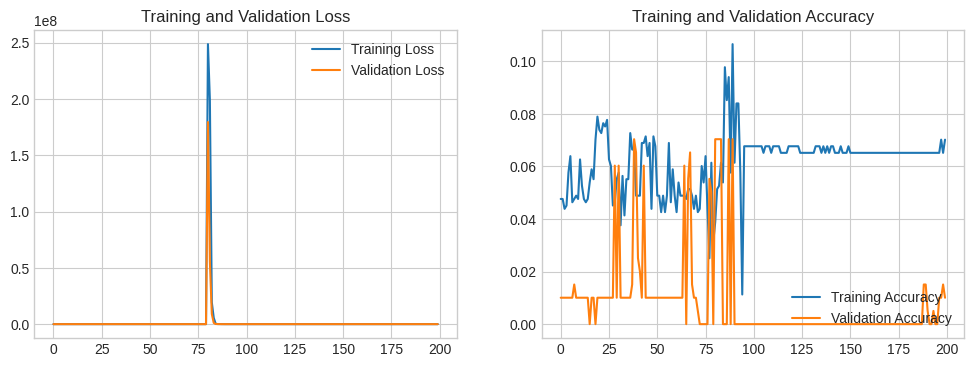

In [ ]:
# 訓練ループ
epochs = 200
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # 訓練データセットの反復
    for step, (batch, labels_batch) in enumerate(train_dataset):
        train_step(batch, labels_batch)
        if step % 10 == 0 and step >= 20:  # 20ステップ経過後に10ステップごとにグラフを更新

            # 訓練の損失と精度を記録
            train_losses.append(train_loss_metric.result())
            train_accuracies.append(train_accuracy_metric.result())

            # 検証データセットの評価
            for val_batch, val_labels_batch in val_dataset:
                val_step(val_batch, val_labels_batch)

            # 検証の損失と精度を記録
            val_losses.append(val_loss_metric.result())
            val_accuracies.append(val_accuracy_metric.result())

            # プロット
            clear_output(wait=True)  # 既存のグラフをクリア
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 2, 1)
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.legend(loc='upper right')
            plt.title('Training and Validation Loss')

            plt.subplot(1, 2, 2)
            plt.plot(train_accuracies, label='Training Accuracy')
            plt.plot(val_accuracies, label='Validation Accuracy')
            plt.legend(loc='lower right')
            plt.title('Training and Validation Accuracy')

            plt.show()

            # メトリックのリセット
            train_loss_metric.reset_states()
            train_accuracy_metric.reset_states()
            val_loss_metric.reset_states()
            val_accuracy_metric.reset_states()

# モデルの保存 (必要に応じて)
# two_tower_model.save('two_tower_model')